In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f;


In [29]:
# Get data on Currency Changes from Yahoo Finance for 5 years
#currency_data = yf.Ticker("EURUSD=X")
#df_currency = currency_data.history(period="5y")

# Export the data to a csv file 
#path = '../Data/eur_usd_exchange_rate.csv'
#df_currency.to_csv(path)

# Read data from csv files
lor_df = pd.read_csv('../Data/loreal_stock_price.csv')
currency_df = pd.read_csv('../Data/eur_usd_exchange_rate.csv')

In [30]:
# Preprocessing data
# Convert to datetime
lor_df['Date'] = pd.to_datetime(lor_df['Date'], errors='coerce', utc = True)
currency_df['Date'] = pd.to_datetime(currency_df['Date'], errors='coerce', utc=True)

# Remove invalid Date
lor_df = lor_df.dropna(subset=['Date'])
currency_df = currency_df.dropna(subset=['Date'])

# Consider only date part
lor_df['Date'] = lor_df['Date'].dt.date

currency_df['Date'] = currency_df['Date'].dt.date

# Merge stock price and currency changes
merged_lor_df = pd.merge(lor_df, currency_df, on='Date', how='inner')

merged_lor_df = merged_lor_df[['Date', 'Close_x', 'Close_y']]

merged_lor_df.columns = ['Date', 'Loreal_Stock', 'Close_currency']

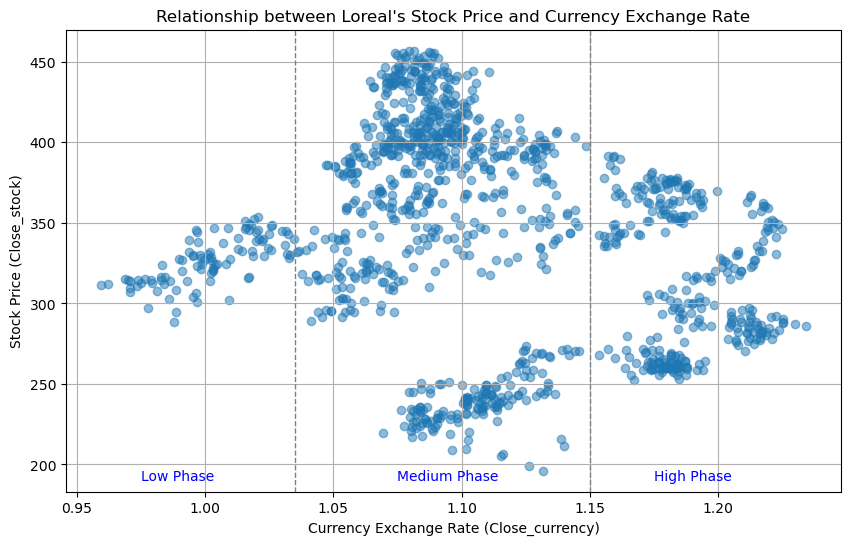

In [31]:
# Plot the relationship between stock price (Close_x) and currency exchange rate (Close_y)
ax, figure = plt.subplots(figsize=(10, 6))
plt.scatter(merged_lor_df['Close_currency'], merged_lor_df['Loreal_Stock'], alpha=0.5)
plt.title("Relationship between Loreal's Stock Price and Currency Exchange Rate")
plt.ylabel('Stock Price (Close_stock)')
plt.xlabel('Currency Exchange Rate (Close_currency)')

plt.axvline(x=1.035, color='grey', linestyle='dashed', linewidth=1)
plt.axvline(x=1.15, color='grey', linestyle='dashed', linewidth=1)

plt.annotate('Low Phase', xy=(0.975, 190), xytext=(0.975, 190), color='Blue')
plt.annotate('Medium Phase', xy=(1.075, 190), xytext=(1.075, 190), color='Blue')
plt.annotate('High Phase', xy=(1.175, 190), xytext=(1.175, 190), color='Blue')
plt.grid(True)
plt.show()

In [ ]:
merged_lor_df['Currency_Bin'] = pd.qcut(merged_lor_df['Close_currency'], q=3, labels=['Low', 'Medium', 'High'])
# ANOVA to determine the correlation between close stock price(dependent) and currency exchange rate(independent)
print('ANOVA Test:')
model = ols('Loreal_Stock ~ C(Currency_Bin)', data=merged_lor_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
df_between = anova_table['sum_sq'][0]
df_within = anova_table['sum_sq'][1]

# Calculate the F-statistic
alpha = 0.05
F_crit = f.ppf(1-alpha, df_between, df_within)
print(f"F critical: {F_crit:.4f}")
print ("===============================================")
correlation = merged_lor_df[['Loreal_Stock', 'Close_currency']].corr().iloc[0, 1]
print ("Pearson's correlation between Loreal stock price and currency exchange rate:")
print(f"R: {correlation:.4f}")


ANOVA Test:
                       sum_sq      df         F        PR(>F)
C(Currency_Bin)  3.542163e+05     2.0  47.24118  1.861039e-20
Residual         4.386354e+06  1170.0       NaN           NaN
F critical: 1.0041
Pearson's correlation between Loreal stock price and currency exchange rate:
R: -0.2276


# Result breakdown

### L'oreal - the most stable

**F-Stat:** The quite high F value(47.241), which is considerably higher than the F critical (1.0041), suggests that we can reject the null hypothesis. But it is also crucial to consider the value of P-value.

**Significance of the Factor:** The p-value is less than 0.05, suggesting that there is a low probability that the relationship between stock price and currency exchange rate is due to random chance. It gives us confidence to say that the relationship observed in the sample likely exists in the population.

**Negative correlation:** Calculating R-value reveals a week negative correlation of -0.2276, indicating that as one variable increases, the other tends to decrease slightly. Although this negative correlation might seem unusual, it can be explain by how exchange rates impact the competitiveness and profitability of European companies. In detail, when the rate decreases(Euro depreciates against the USD), European exports become cheaper for consumers and businesses in USD-using countries. This increases the competitiveness of European companies in the international market, potentially boosting their sales and profits, leading to a subtle increase in their stock price.

***In conclusion, based on the ANOVA result, we can state that the currency exchange rate have a statistically significant but weak effect on Loreal's stock price***



c:\Users\lamma\anaconda3\envs\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lamma\anaconda3\envs\NLP\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


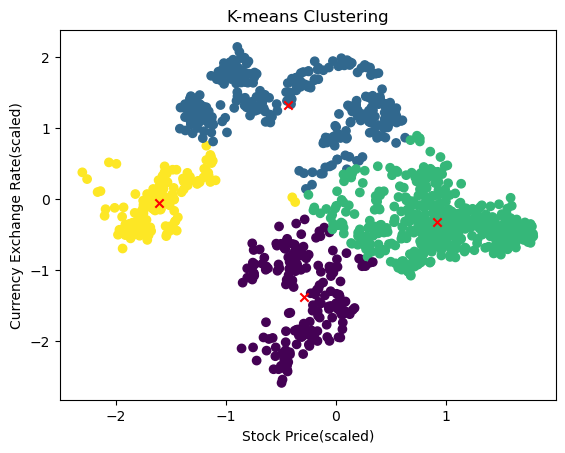

In [ ]:
# K-Means
data = merged_lor_df[['Loreal_Stock', 'Close_currency']].values

# Standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# KMeans algorithm with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(data_scaled)
labels = kmeans.predict(data_scaled)
centroids = kmeans.cluster_centers_

# Plot k-means clustering
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('Stock Price(scaled)')
plt.ylabel('Currency Exchange Rate(scaled)')
plt.title('K-means Clustering')
plt.show()

### Result breakdown

This K-Means clustering algorithm has grouped the data points into four clusters with four different colors. This suggests that there are different patterns in the relationship. 

*The yellow cluster* is centered around lower stock prices and a narrow range of exchange rates, representing a stable period with specific economic conditions.

*The blue and green clusters* cover higher ranges of stock prices and are spread more widely in exchange rate values, indicating more volatility or variation in currency exchange rates during these periods.

*The purple cluster* is concentrated at lower stock prices with varying exchange rates, possibly representing a period of reduced stock market performance or lower economic stability.

***In conclusion, the scatter plot and k-means plot might show a lot of variability and not clearly reflect the negative correlation due to the weak relationship with currency exchange rate and the influence of many factors, especially business indices.***